https://chatgpt.com/share/68703dc5-4ff0-8008-9153-42348685b941

In [82]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np

In [23]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 15,  # 默认字体大小
        "axes.titlesize": 17,  # 标题字体
        "axes.labelsize": 15,  # 坐标轴标签
        "xtick.labelsize": 13,  # x 轴刻度
        "ytick.labelsize": 13,  # y 轴刻度
        "legend.fontsize": 13,  # 图例字体
    }
)

In [2]:
CREDENTIALS_JSON = '../rm4mt-463314-3ce1280ee29c.json'
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [3]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [4]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [24]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric


dfs_by_metric = split_by_metric(all_data)

In [25]:
print("Available Metrics:")
print(list(dfs_by_metric.keys()))

Available Metrics:
['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length']


In [26]:
dfs_by_metric['comet_score']

,model,task,metric,lang_pair,budget,score
0,DRT-14B,WMT23-Biomedical-Doc,comet_score,Avg,100,0.727978
1,DRT-14B,WMT23-Biomedical-Doc,comet_score,Avg,200,0.718425
2,DRT-14B,WMT23-Biomedical-Doc,comet_score,Avg,300,0.718396
3,DRT-14B,WMT23-Biomedical-Doc,comet_score,Avg,400,0.715491
4,DRT-14B,WMT23-Biomedical-Doc,comet_score,Avg,500,0.726203
...,...,...,...,...,...,...
5924,cogito-v1-preview-llama-8B,RAGtrans,comet_score,en-zh,2000,0.782715
5925,grok-3-mini,RAGtrans,comet_score,Avg,high,0.846193
5926,grok-3-mini,RAGtrans,comet_score,Avg,low,0.844979
5927,grok-3-mini,RAGtrans,comet_score,en-zh,high,0.846193


In [27]:
dfs_by_metric["comet_score"]["model"].unique()

array(['DRT-14B', 'DRT-7B', 'DRT-8B', 'Qwen3-0.6B', 'Qwen3-1.7B',
       'Qwen3-14B', 'Qwen3-32B', 'Qwen3-4B', 'Qwen3-8B',
       'cogito-v1-preview-llama-3B', 'cogito-v1-preview-llama-8B',
       'grok-3-mini'], dtype=object)

In [28]:
def plot_model_scores(
    df, 
    task, 
    lang_pair, 
    models,
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(7,5)
):
    plot_df = df[
        (df['task'] == task) &
        (df['lang_pair'] == lang_pair) &
        (df['model'].isin(models))
    ]
    if plot_df.empty:
        print('No data found for the given criteria. Please check')
        return
    
    plt.figure(figsize=figsize)
    for model in models:
        sub = plot_df[plot_df['model'] == model]
        sub = sub.sort_values('budget')
        plt.plot(sub['budget'], sub['score'], marker='o', label=model)
    plt.xlabel('Budget')
    plt.ylabel('Score')
    plt.title(f'{task} | {lang_pair}')
    plt.xticks(budget_ticks)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [29]:
# plot_model_scores(
#     dfs_by_metric['comet_score'],
#     task='WMT23-Biomedical-Sentence',
#     lang_pair='Avg',
#     # models=['Qwen3-0.6B', 'Qwen3-1.7B']
#     # models=['Qwen3-4B', 'Qwen3-8B']
#     # models=['Qwen3-14B', 'Qwen3-32B']
# )

In [30]:
def sort_budget_key(b):
    if isinstance(b, (int, float)):
        return (0, b)
    elif isinstance(b, str):
        if b.isdigit():
            return (0, int(b))
        elif b == "low":
            return (1, 0)
        elif b == "high":
            return (2, 0)
    return (3, str(b))


def plot_models_groups_side_by_side(
    df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=None,
    figsize=(16, 5),
):
    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]

    for idx, models in enumerate(model_groups):
        ax = axes[idx]
        group_df = df[
            (df["task"] == task)
            & (df["metric"] == metric)
            & (df["lang_pair"] == lang_pair)
            & (df["model"].isin(models))
        ]
        if group_df.empty:
            ax.set_title("No data available for this group")
            continue

        # First, determine the nature of the budget axis for this group
        all_budgets = set(group_df["budget"])
        sorted_budgets = sorted(all_budgets, key=sort_budget_key)
        is_numeric_group = all(
            isinstance(b, (int, float)) or (isinstance(b, str) and b.isdigit())
            for b in sorted_budgets
        )

        # Plot each model in the group
        for model in models:
            sub = group_df[group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))

            x_values = sub["budget"]
            if is_numeric_group:
                # If all budgets are numeric-like, plot them as numbers
                x_values = x_values.astype(int)
            else:
                # Otherwise, plot as strings (categorical)
                x_values = x_values.astype(str)

            ax.plot(x_values, sub["score"], marker="o", label=model)

        # Set the x-ticks based on whether the axis is numeric or categorical
        if is_numeric_group:
            # For a numeric axis, set numeric ticks
            ticks = (
                budget_ticks
                if budget_ticks is not None
                else [int(b) for b in sorted_budgets]
            )
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks, rotation=45)
        else:
            # For a categorical axis, set string ticks
            xticks = [str(b) for b in sorted_budgets]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=45)

        ax.set_xlabel("Budget")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("Score")
        ax.legend(loc="lower right", framealpha=0.25)

    plt.suptitle(f"{task} | {metric} | {lang_pair}")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

### Biomedical Translation

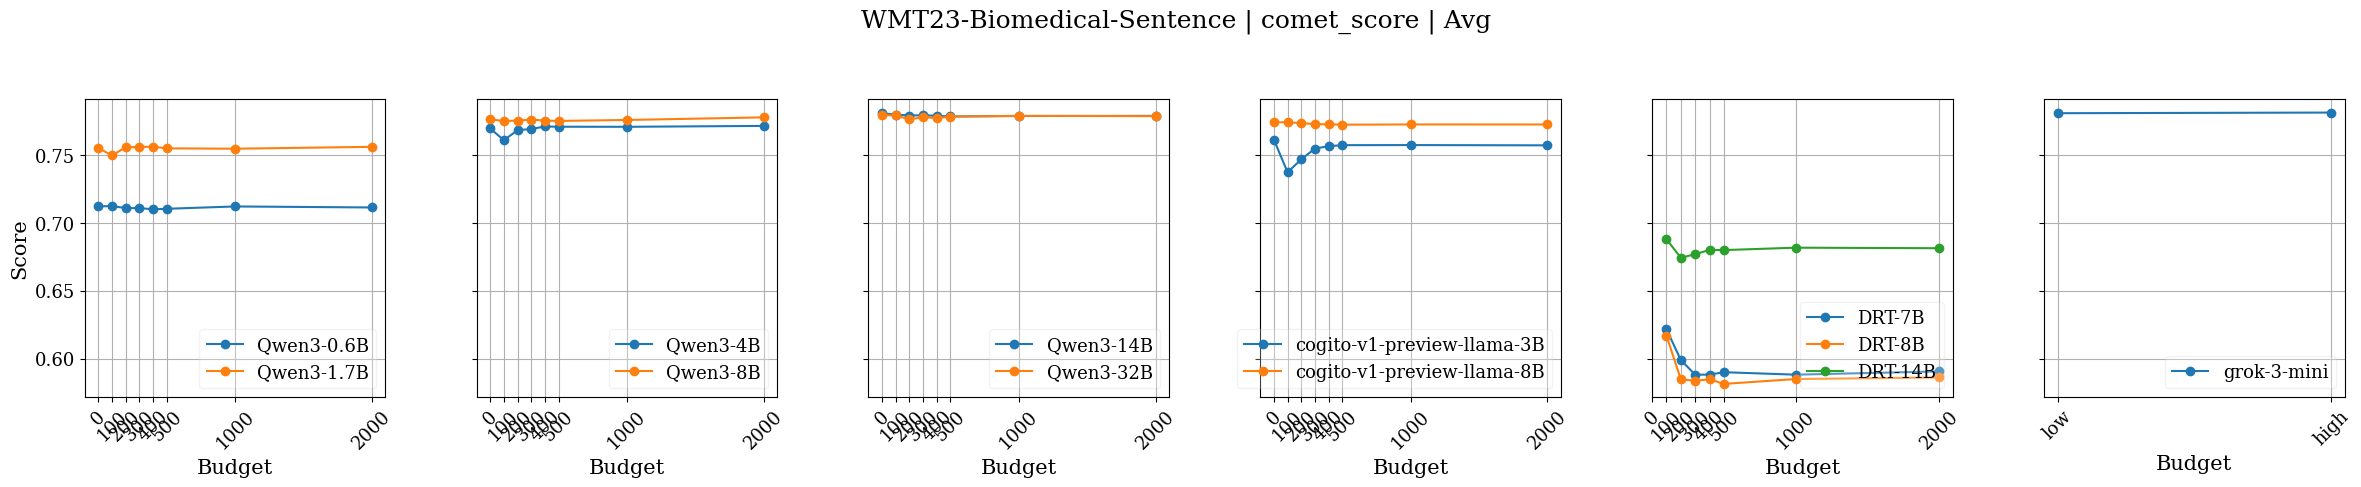

In [31]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="WMT23-Biomedical-Sentence",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

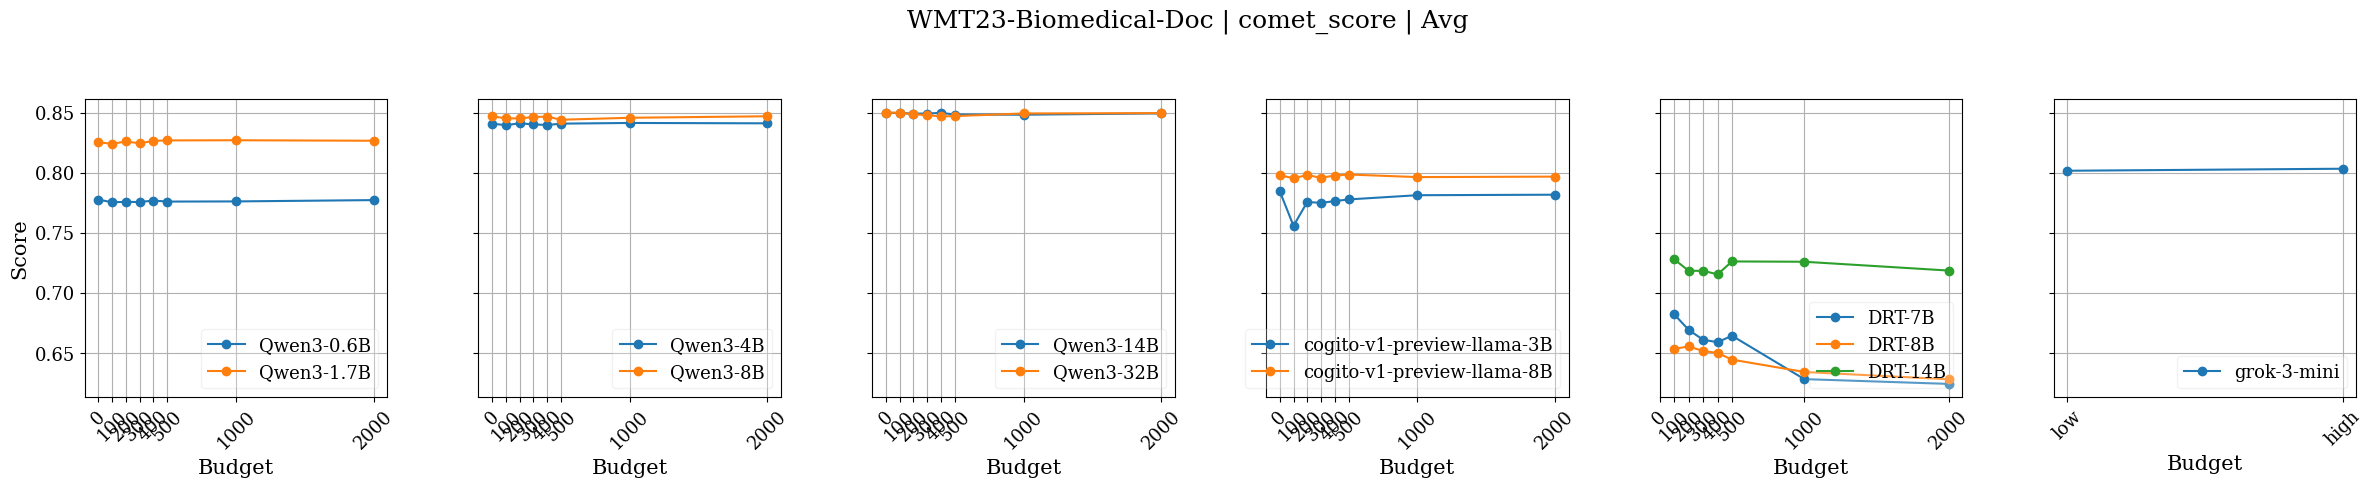

In [32]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="WMT23-Biomedical-Doc",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

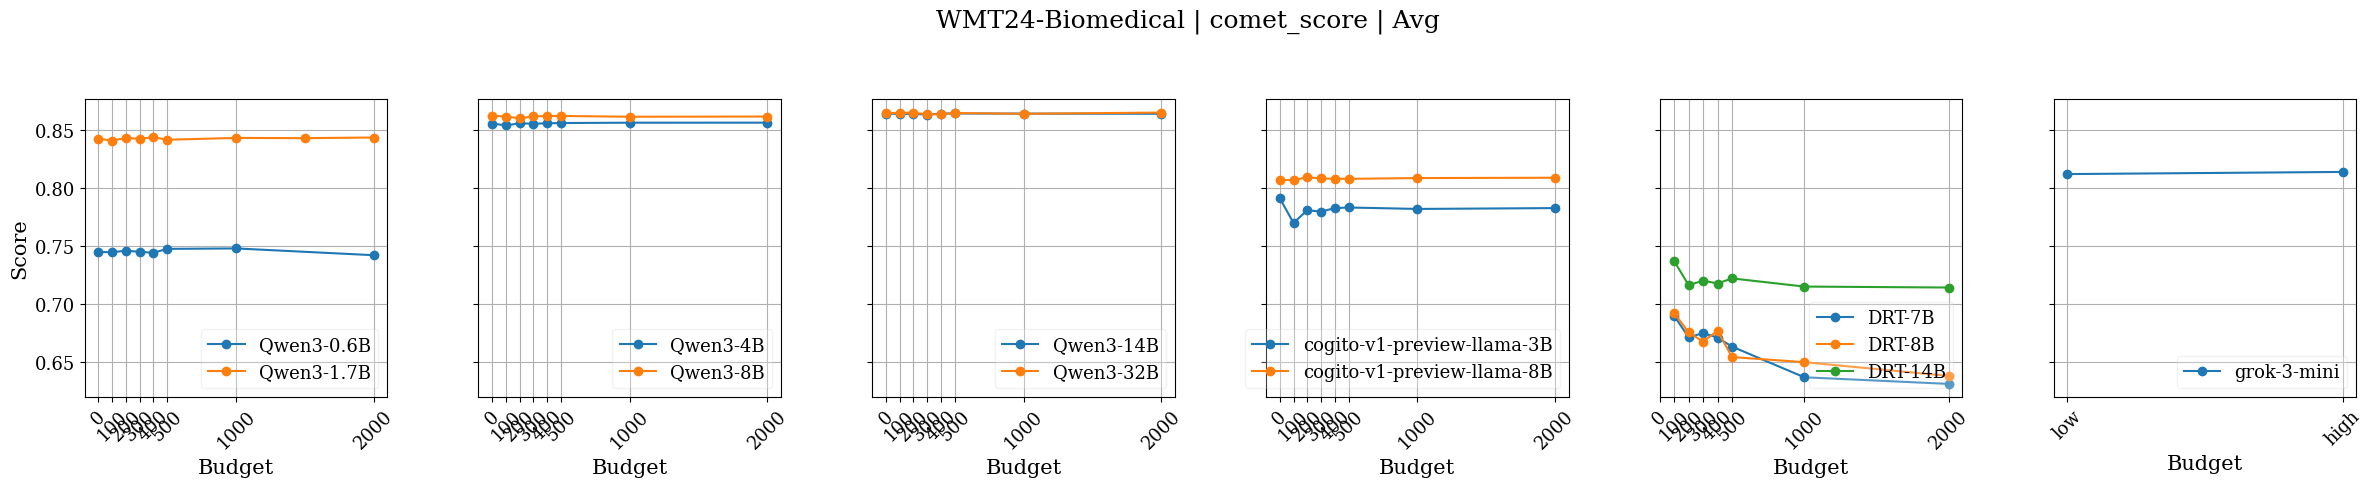

In [33]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="WMT24-Biomedical",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Terminminology Translation

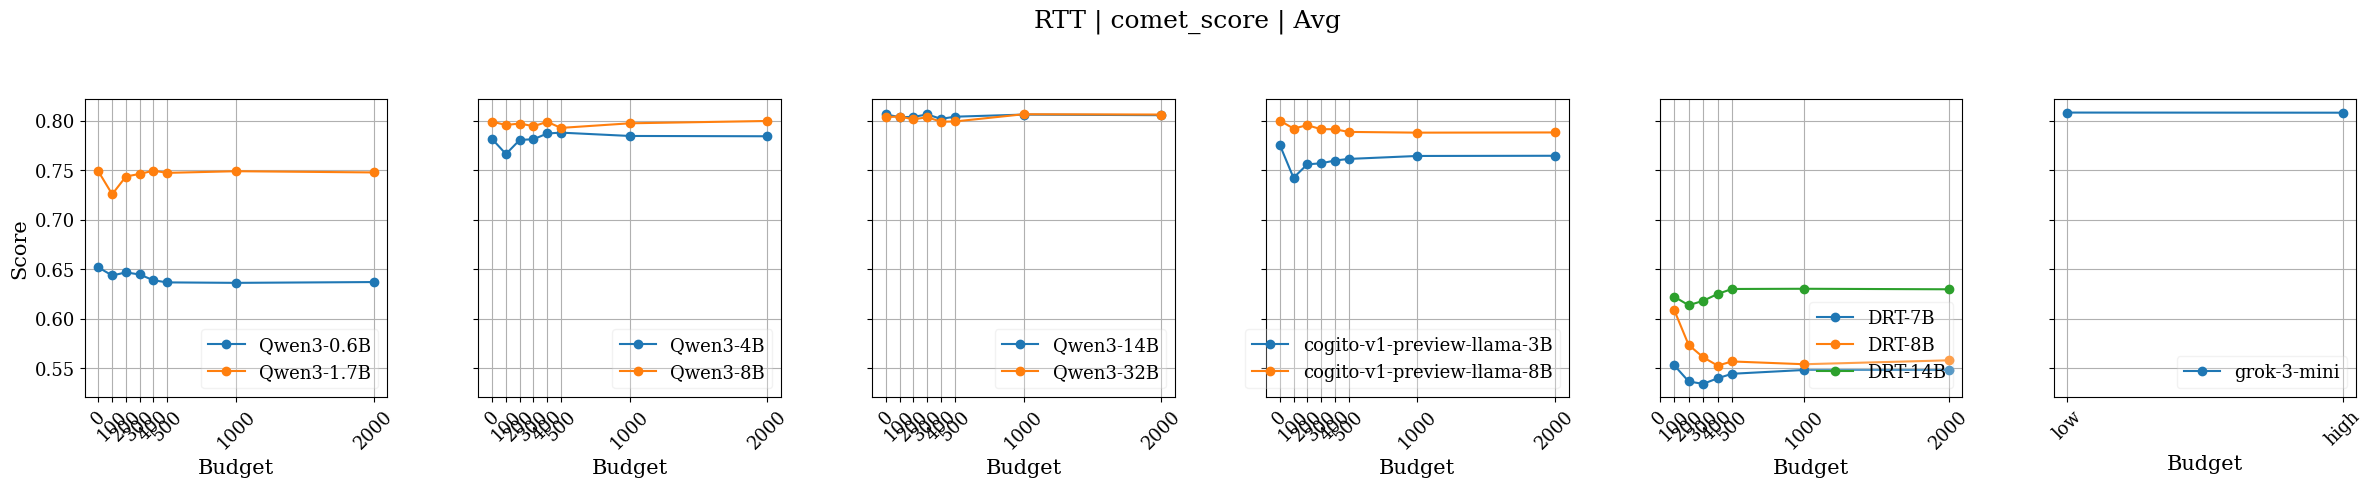

In [34]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="RTT",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Commosence Translation

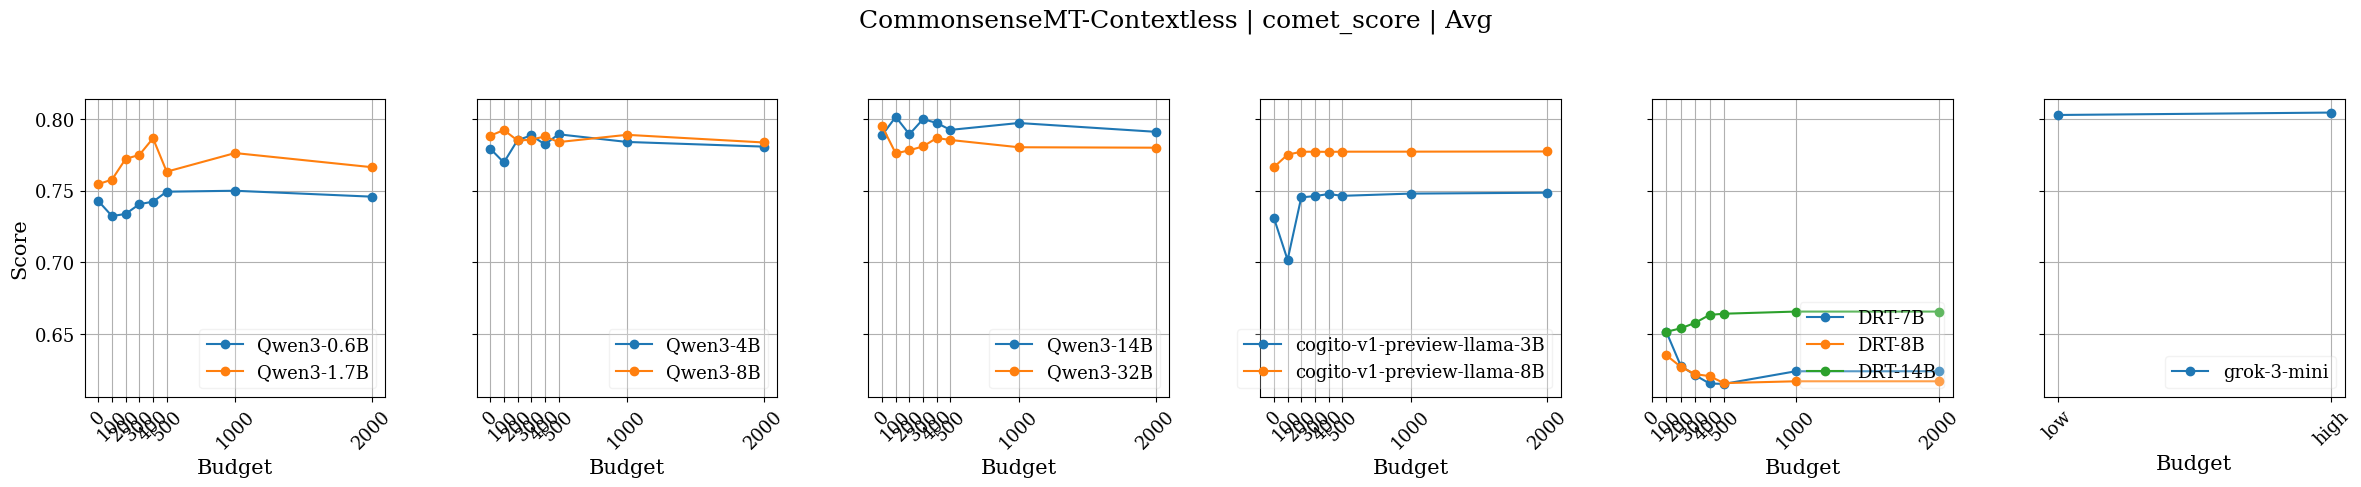

In [35]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="CommonsenseMT-Contextless",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

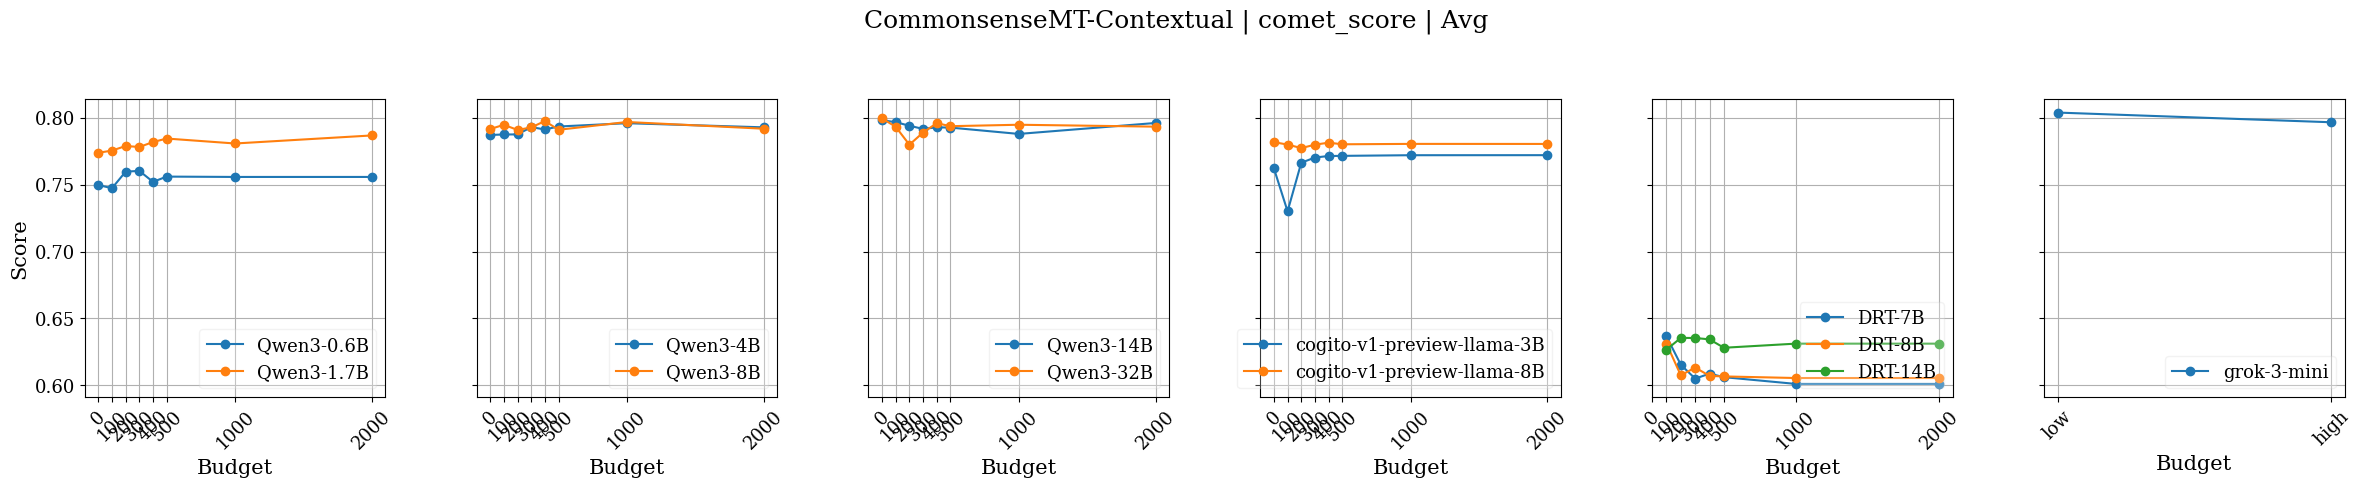

In [36]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="CommonsenseMT-Contextual",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

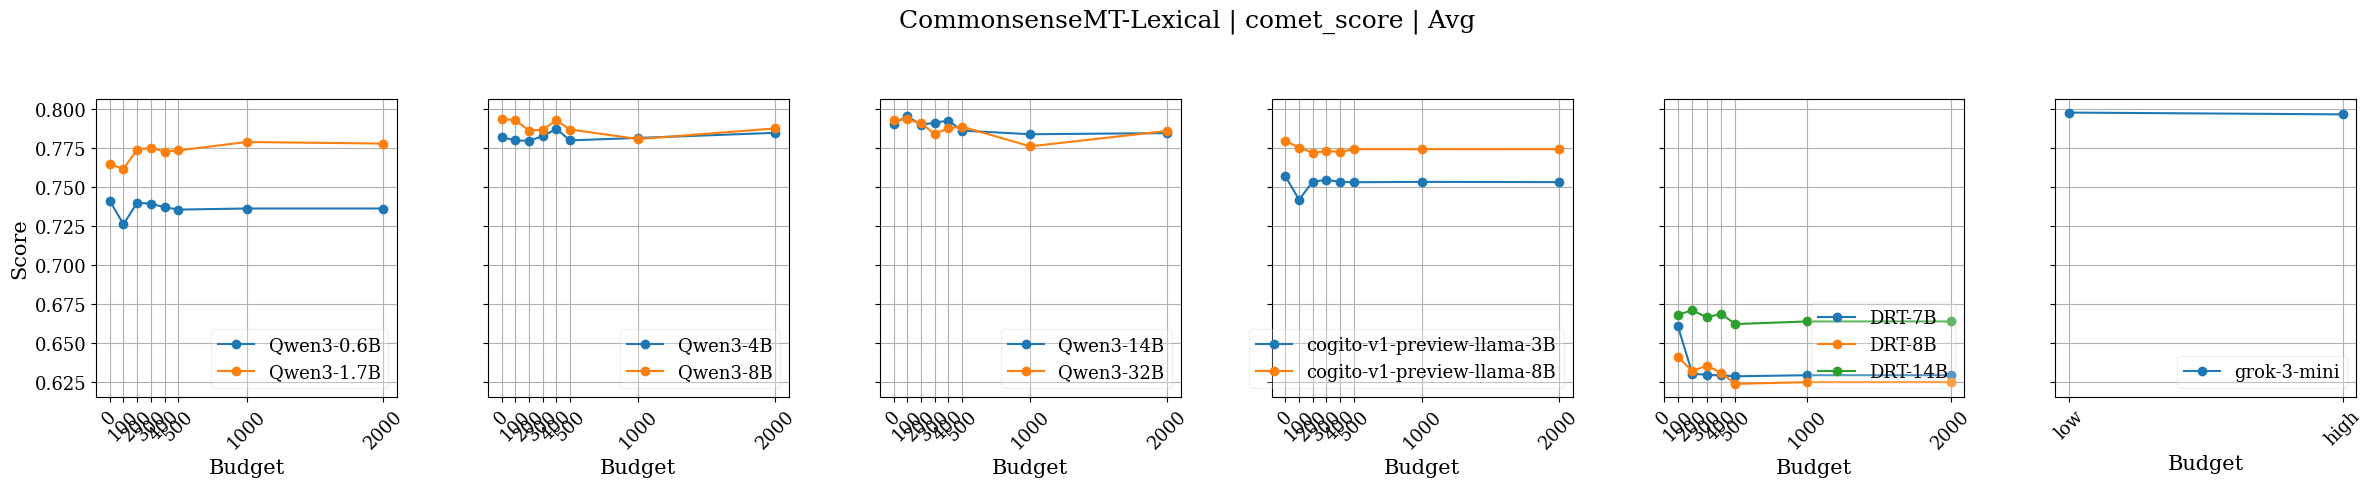

In [37]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="CommonsenseMT-Lexical",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Culture Translation

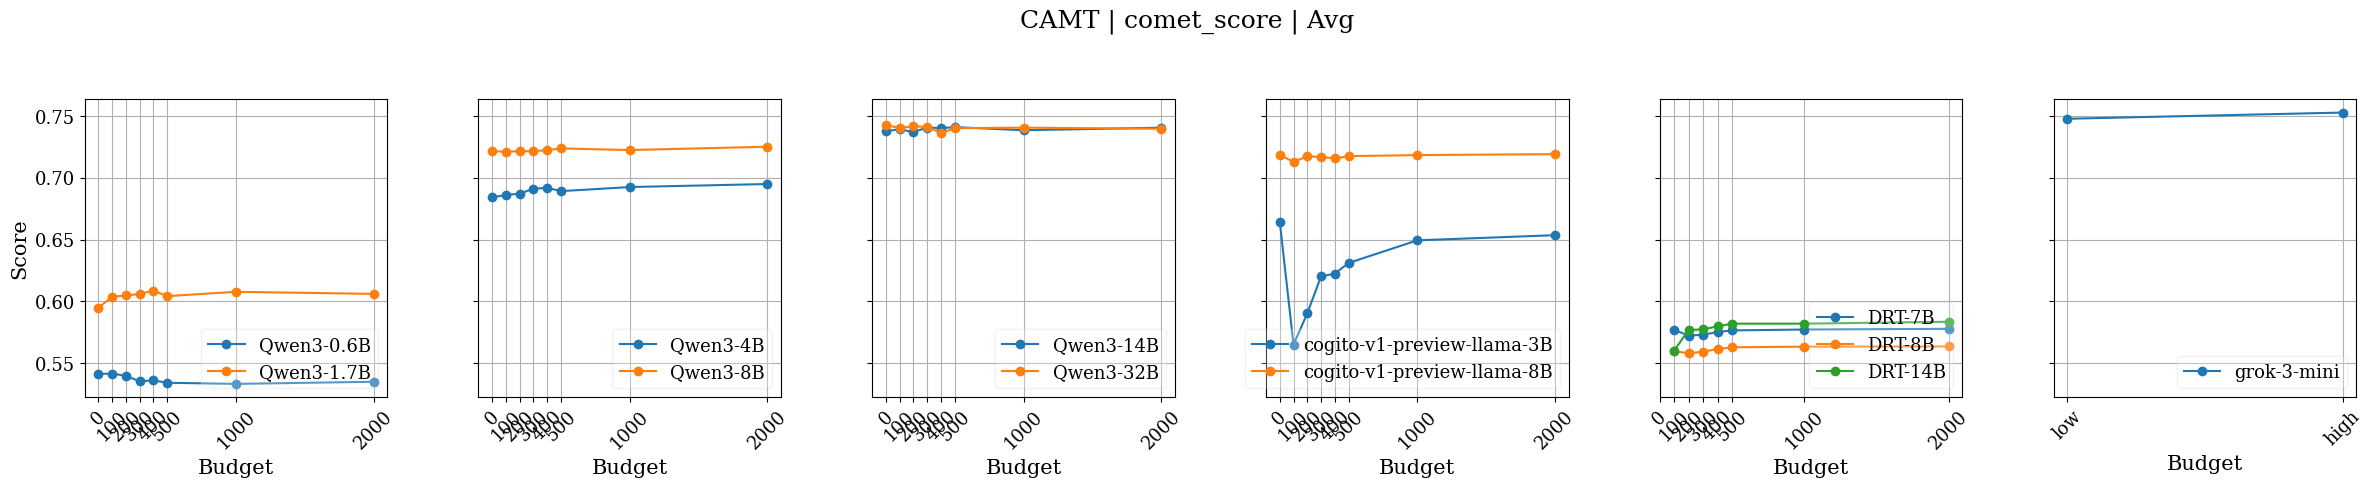

In [38]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="CAMT",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Literterature Transaltion

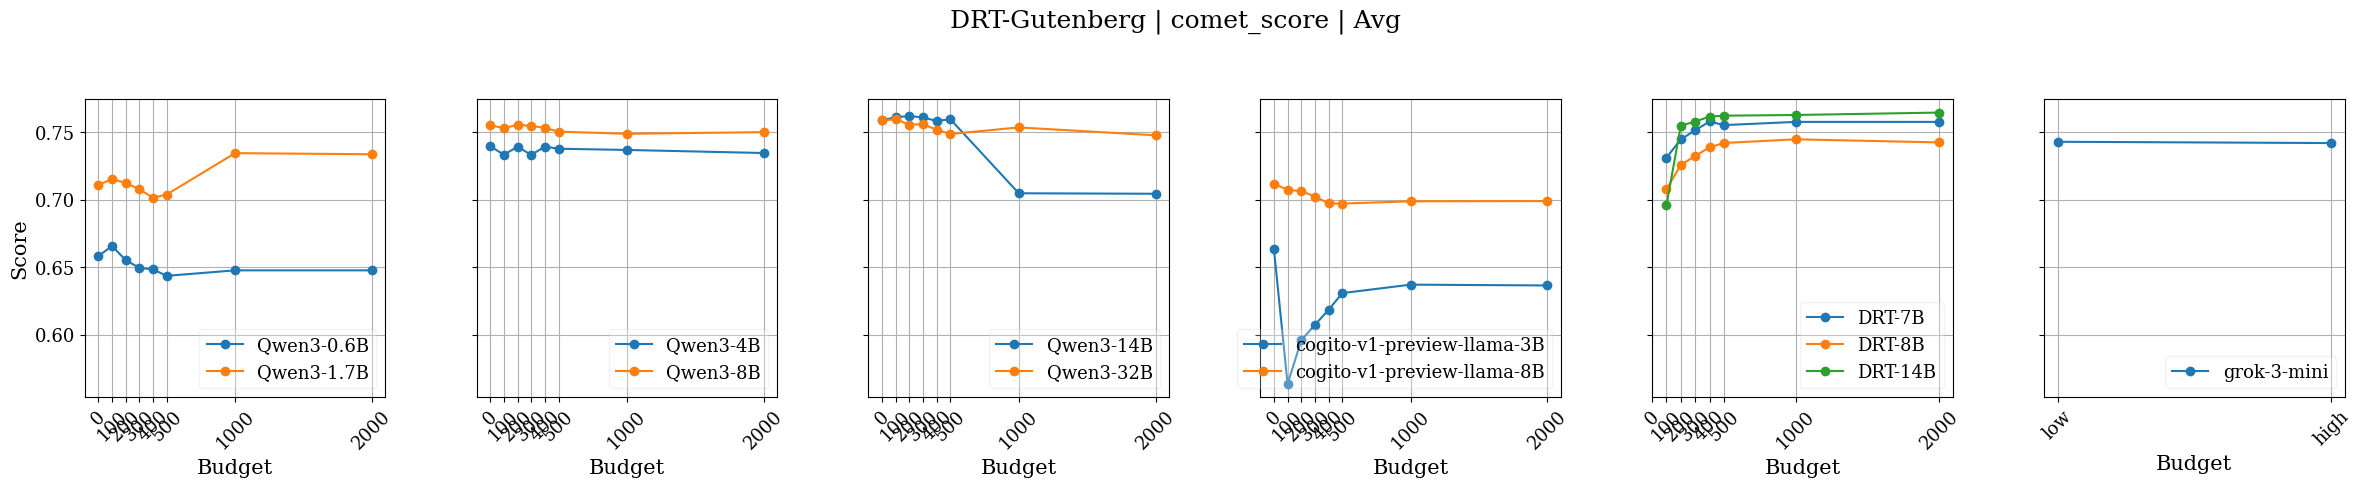

In [39]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="DRT-Gutenberg",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

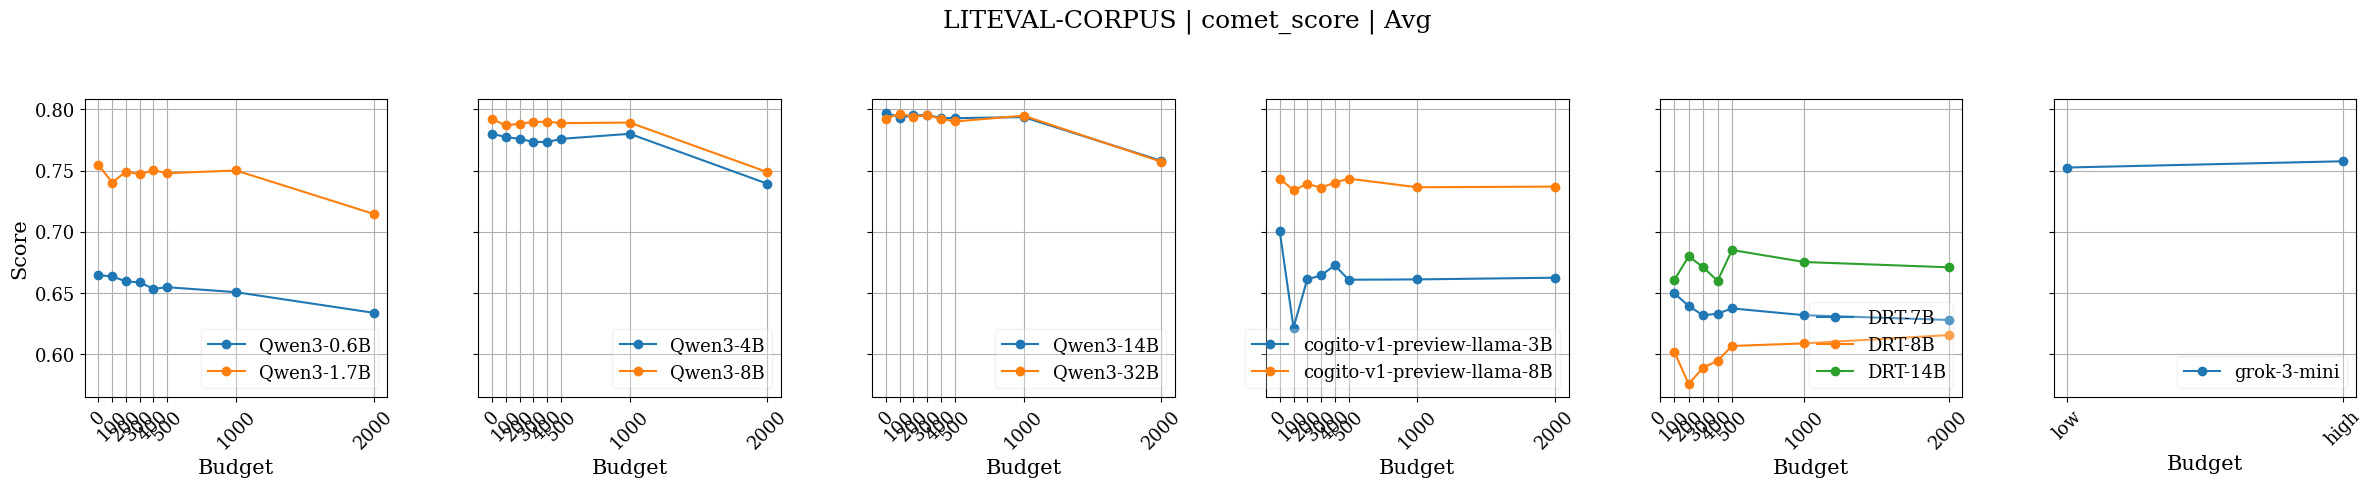

In [40]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="LITEVAL-CORPUS",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### RAG Transaltion

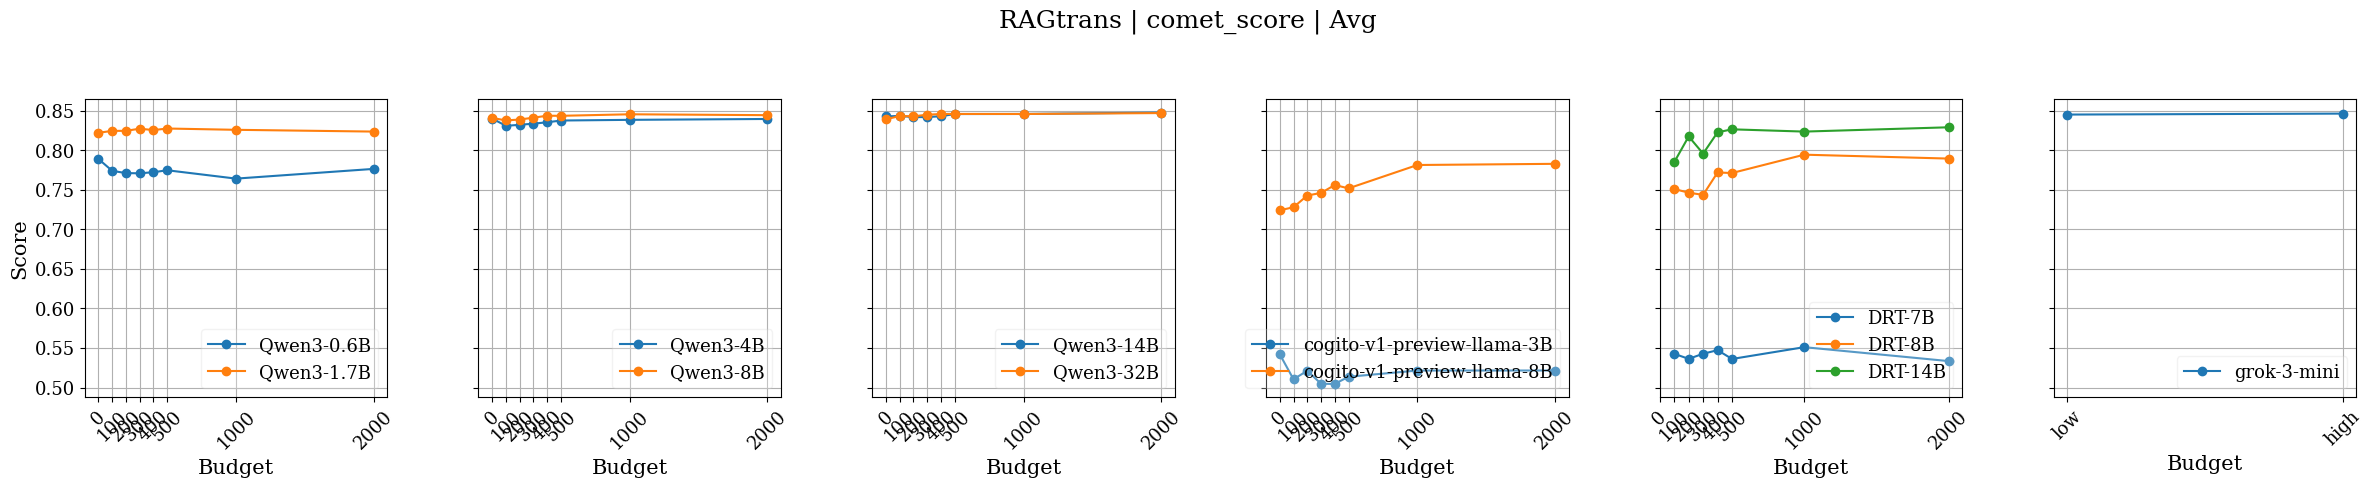

In [41]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_score"],
    task="RAGtrans",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

In [69]:
def calculate_average_scores_across_datasets(df, metric):
    """
    计算所有数据集（tasks）的平均分数

    参数:
    df: 包含所有数据的DataFrame
    metric: 指标名称 (如 'grb')

    返回:
    average_df: 包含平均分数的DataFrame，task列被设置为'Average-All-Datasets'
    """
    # 过滤指定的metric
    metric_df = df[df["metric"] == metric].copy()
    metric_df = metric_df[metric_df["task"] != "WMT23-Biomedical-Sentence"].reset_index(
        drop=True
    )

    if metric_df.empty:
        print(f"No data found for metric: {metric}")
        return pd.DataFrame()

    # 按 model, lang_pair, budget 分组，计算所有tasks的平均分数
    avg_df = (
        metric_df.groupby(["model", "lang_pair", "budget"])["score"]
        .mean()
        .reset_index()
    )

    # 添加其他必要的列
    avg_df["task"] = "Average-All-Datasets"
    avg_df["metric"] = metric

    # 重新排列列的顺序以匹配原始DataFrame
    avg_df = avg_df[["model", "task", "metric", "lang_pair", "budget", "score"]]

    return avg_df


comet_average_df = calculate_average_scores_across_datasets(
    dfs_by_metric["comet_score"], "comet_score"
)
comet_average_df = comet_average_df[comet_average_df["budget"] != 1500]
comet_average_df["model"] = comet_average_df["model"].replace(
    "cogito-v1-preview-llama-3B", "Cogito-3B"
)
comet_average_df["model"] = comet_average_df["model"].replace(
    "cogito-v1-preview-llama-8B", "Cogito-8B"
)
comet_average_df["model"] = comet_average_df["model"].replace(
    "grok-3-mini", "Grok-3-Mini"
)
print("Average scores calculated for all datasets")
print(f"Shape: {comet_average_df.shape}")
print("\nSample data:")
print(comet_average_df.head(10))

Average scores calculated for all datasets
Shape: (1827, 6)

Sample data:
     model                  task       metric lang_pair budget     score
0  DRT-14B  Average-All-Datasets  comet_score       Avg    100  0.658897
1  DRT-14B  Average-All-Datasets  comet_score       Avg    200  0.670277
2  DRT-14B  Average-All-Datasets  comet_score       Avg    300  0.665895
3  DRT-14B  Average-All-Datasets  comet_score       Avg    400  0.670655
4  DRT-14B  Average-All-Datasets  comet_score       Avg    500  0.671086
5  DRT-14B  Average-All-Datasets  comet_score       Avg   1000  0.671624
6  DRT-14B  Average-All-Datasets  comet_score       Avg   2000  0.671739
7  DRT-14B  Average-All-Datasets  comet_score     de-en    100  0.732980
8  DRT-14B  Average-All-Datasets  comet_score     de-en    200  0.713209
9  DRT-14B  Average-All-Datasets  comet_score     de-en    300  0.695890


In [70]:
def plot_models_groups_side_by_side_single_xlabel(
    df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=None,
    figsize=(16, 5),
    output_name=None,
):
    """
    与原函数相同，但只显示一个居中的x轴标签
    """
    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]

    for idx, models in enumerate(model_groups):
        ax = axes[idx]
        group_df = df[
            (df["task"] == task)
            & (df["metric"] == metric)
            & (df["lang_pair"] == lang_pair)
            & (df["model"].isin(models))
        ]
        if group_df.empty:
            ax.set_title("No data available for this group")
            continue

        # First, determine the nature of the budget axis for this group
        all_budgets = set(group_df["budget"])
        sorted_budgets = sorted(all_budgets, key=sort_budget_key)
        is_numeric_group = all(
            isinstance(b, (int, float)) or (isinstance(b, str) and b.isdigit())
            for b in sorted_budgets
        )

        # Plot each model in the group
        for model in models:
            sub = group_df[group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))

            x_values = sub["budget"]
            if is_numeric_group:
                # If all budgets are numeric-like, plot them as numbers
                x_values = x_values.astype(int)
            else:
                # Otherwise, plot as strings (categorical)
                x_values = x_values.astype(str)

            ax.plot(x_values, sub["score"], marker="o", label=model)

        # Set the x-ticks based on whether the axis is numeric or categorical
        if is_numeric_group:
            # For a numeric axis, set numeric ticks
            ticks = (
                budget_ticks
                if budget_ticks is not None
                else [int(b) for b in sorted_budgets]
            )
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks, rotation=45)
        else:
            # For a categorical axis, set string ticks
            xticks = [str(b) for b in sorted_budgets]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=45)

        # 不在每个子图上设置xlabel
        # ax.grid(True)
        ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.7)
        if idx == 0:
            ax.set_ylabel(f"{metric.upper()} Score")
        ax.legend(loc="lower right", framealpha=0.25)

    # 在整个图表底部添加一个居中的x轴标签
    fig.text(0.5, 0.02, "Thinking Budget (Tokens)", ha="center", fontsize=12)

    # plt.suptitle(f"{task} | {metric} | {lang_pair}")
    plt.tight_layout(rect=[0, 0.05, 1, 0.94])  # 为底部标签留出空间
    plt.savefig(output_name, dpi=900, bbox_inches="tight")
    plt.show()

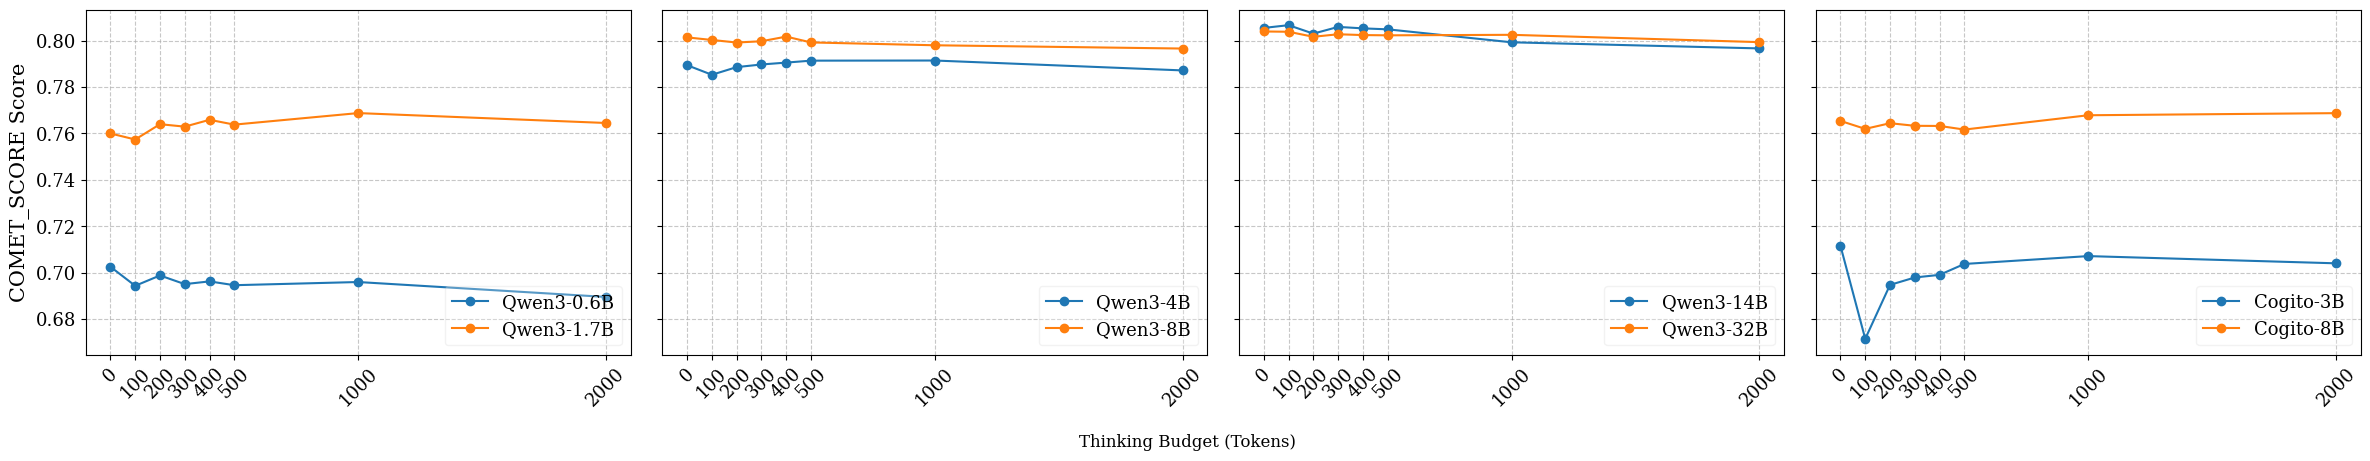

In [71]:
plot_models_groups_side_by_side_single_xlabel(
    comet_average_df,
    task="Average-All-Datasets",
    metric="comet_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["Cogito-3B", "Cogito-8B"],
        # ["DRT-7B", "DRT-8B", "DRT-14B"],
        # ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
    # output_name="qwen_and_cogito_comet_average.png",
    output_name="qwen_and_cogito_comet_average.pdf",
)

In [72]:
comet_average_df

,model,task,metric,lang_pair,budget,score
0,DRT-14B,Average-All-Datasets,comet_score,Avg,100,0.658897
1,DRT-14B,Average-All-Datasets,comet_score,Avg,200,0.670277
2,DRT-14B,Average-All-Datasets,comet_score,Avg,300,0.665895
3,DRT-14B,Average-All-Datasets,comet_score,Avg,400,0.670655
4,DRT-14B,Average-All-Datasets,comet_score,Avg,500,0.671086
...,...,...,...,...,...,...
1835,Grok-3-Mini,Average-All-Datasets,comet_score,zh-de,low,0.806517
1836,Grok-3-Mini,Average-All-Datasets,comet_score,zh-en,high,0.806102
1837,Grok-3-Mini,Average-All-Datasets,comet_score,zh-en,low,0.807335
1838,Grok-3-Mini,Average-All-Datasets,comet_score,zh-ru,high,0.839445


In [73]:
comet_average_df = comet_average_df[
    (comet_average_df["task"] == "Average-All-Datasets")
    & (comet_average_df["lang_pair"] == "Avg")
]

In [74]:
comet_average_df

,model,task,metric,lang_pair,budget,score
0,DRT-14B,Average-All-Datasets,comet_score,Avg,100,0.658897
1,DRT-14B,Average-All-Datasets,comet_score,Avg,200,0.670277
2,DRT-14B,Average-All-Datasets,comet_score,Avg,300,0.665895
3,DRT-14B,Average-All-Datasets,comet_score,Avg,400,0.670655
4,DRT-14B,Average-All-Datasets,comet_score,Avg,500,0.671086
...,...,...,...,...,...,...
1635,Cogito-8B,Average-All-Datasets,comet_score,Avg,500,0.761615
1636,Cogito-8B,Average-All-Datasets,comet_score,Avg,1000,0.767786
1637,Cogito-8B,Average-All-Datasets,comet_score,Avg,2000,0.768693
1798,Grok-3-Mini,Average-All-Datasets,comet_score,Avg,high,0.795159


In [83]:
def latex_table_for_metric(
    df: pd.DataFrame,
    task="Average-All-Datasets",
    metric_name="comet_score",
    budgets_order=(100, 200, 300, 500, 1000, 2000, "low", "high"),
    float_digits=3,
    caption="Average performance across budgets",
    label="tab:avg_comet",
):
    sub = df[(df["task"] == task) & (df["metric"] == metric_name)].copy()

    # 统一 budget 类型（把能转成整数的先转掉）
    def norm_budget(x):
        try:
            return int(x)
        except Exception:
            return x

    sub["budget"] = sub["budget"].map(norm_budget)

    # 列顺序
    budgets = [b for b in budgets_order if b in sub["budget"].unique().tolist()]
    sub["budget"] = pd.Categorical(sub["budget"], categories=budgets, ordered=True)

    # 透视成宽表（数值）
    wide = sub.pivot_table(
        index="model", columns="budget", values="score", aggfunc="mean"
    )
    wide = wide.reindex(columns=budgets)

    # -------- 生成字符串版并加粗行内最大值 --------
    formatted = wide.applymap(lambda v: f"{v:.{float_digits}f}" if pd.notna(v) else "")

    row_max = wide.max(axis=1, skipna=True)  # 每行最大值
    for idx in wide.index:
        for col in wide.columns:
            v = wide.loc[idx, col]
            # if pd.notna(v) and np.isclose(v, row_max.loc[idx]):
            #     formatted.loc[idx, col] = f"\\textbf{{{float(v):.{float_digits}f}}}"

    formatted.index.name = "Model"
    formatted.columns = [str(c) for c in formatted.columns]

    latex = formatted.to_latex(
        escape=False,
        index=True,
        column_format="l" + "c" * formatted.shape[1],
        caption=caption,
        label=label,
        longtable=False,
        multicolumn=True,
        multicolumn_format="c",
        bold_rows=False,
    )
    return latex


latex_code = latex_table_for_metric(
    comet_average_df,
    task="Average-All-Datasets",
    metric_name="comet_score",
    budgets_order=(0, 100, 200, 300, 500, 1000, 2000, "low", "high"),
)
print(latex_code)

\begin{table}
\caption{Average performance across budgets}
\label{tab:avg_comet}
\begin{tabular}{lccccccccc}
\toprule
 & 0 & 100 & 200 & 300 & 500 & 1000 & 2000 & low & high \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
Cogito-3B & 0.712 & 0.671 & 0.695 & 0.698 & 0.704 & 0.707 & 0.704 &  &  \\
Cogito-8B & 0.765 & 0.762 & 0.764 & 0.763 & 0.762 & 0.768 & 0.769 &  &  \\
DRT-14B &  & 0.659 & 0.670 & 0.666 & 0.671 & 0.672 & 0.672 &  &  \\
DRT-7B &  & 0.629 & 0.617 & 0.614 & 0.614 & 0.609 & 0.605 &  &  \\
DRT-8B &  & 0.634 & 0.624 & 0.624 & 0.624 & 0.626 & 0.625 &  &  \\
Grok-3-Mini &  &  &  &  &  &  &  & 0.794 & 0.795 \\
Qwen3-0.6B & 0.702 & 0.694 & 0.699 & 0.695 & 0.695 & 0.696 & 0.689 &  &  \\
Qwen3-1.7B & 0.760 & 0.757 & 0.764 & 0.763 & 0.764 & 0.769 & 0.764 &  &  \\
Qwen3-14B & 0.805 & 0.807 & 0.803 & 0.806 & 0.805 & 0.799 & 0.797 &  &  \\
Qwen3-32B & 0.804 & 0.804 & 0.802 & 0.803 & 0.802 & 0.802 & 0.799 &  &  \\
Qwen3-4B & 0.789 & 0.785 & 0.789 & 0.790 & 0.791 & 0.791 & 0.787 &  &  \

C:\Users\zihao\AppData\Local\Temp\ipykernel_32400\3508109671.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = sub.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_32400\3508109671.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = wide.applymap(lambda v: f"{v:.{float_digits}f}" if pd.notna(v) else "")
